# NEAT_for_Pong
Using **NeuroEvolution of Augmenting Topologies** (NEAT) to train a Pong Game.

Reference:
 - Pong_in_Pygame (Author: clear-code-projects)
    + Youtube: https://www.youtube.com/playlist?list=PL8ui5HK3oSiEk9HaKoVPxSZA03rmr9Z0k
    + Github: https://github.com/clear-code-projects/Pong_in_Pygame
 - NEAT-Pong (Author: John-Trager)
    + Github: https://github.com/John-Trager/NEAT-Pong
 - NEAT paper http://nn.cs.utexas.edu/downloads/papers/stanley.cec02.pdf
 - NEAT-python https://neat-python.readthedocs.io/en/latest/index.html


## **Preparation**
---

###Install neat-python
1. Obtain the source code by cloning the source repository from Github
2. Run setup.py in the neat-python direcory

In [ ]:
!git clone https://github.com/CodeReclaimers/neat-python.git

Cloning into 'neat-python'...
remote: Enumerating objects: 5311, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 5311 (delta 125), reused 164 (delta 93), pack-reused 5058
Receiving objects: 100% (5311/5311), 2.25 MiB | 7.01 MiB/s, done.
Resolving deltas: 100% (3638/3638), done.


In [ ]:
%cd neat-python
!python setup.py install
import neat

/content/neat-python
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        ot

# **install pygame**

In [ ]:
!pip install pygame

To enable pygame on Colab, we have to fool the system to think it has a video card access.

So we assign a dummy video driver.

And the display is achieved by matplotlib im_show()

In [ ]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
%matplotlib inline

Git-clone repository from my [Github](https://github.com/yenzu0329/NEAT_for_Pong)

The repo contains
- **result**  (folder that save the training result and demo video)
- pong.py
- winner.pkl
- config-feedforward.txt
- main.py  (code for training)
- test.py  (code for testing)
- visualize.py (for visualize the network of NEAT)


In [ ]:
%cd ..
!git clone https://github.com/yenzu0329/NEAT_for_Pong.git

/content
Cloning into 'NEAT_for_Pong'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 39 (delta 9), reused 31 (delta 5), pack-reused 0
Receiving objects: 100% (39/39), 901.68 KiB | 3.58 MiB/s, done.
Resolving deltas: 100% (9/9), done.


# **Training**
---

First import necessary libraries

In [ ]:
%cd NEAT_for_Pong
import neat
import pickle, gzip
import os
import visualize
from pong import *

/content/NEAT_for_Pong
pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


- `save_object` - save the model to a pickle file
- `load_object` - load the model from a pickle file


In [ ]:
def save_object(obj, filename):
    with gzip.open(filename, 'w', compresslevel=5) as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with gzip.open(filename) as f:
        obj = pickle.load(f)
        return obj



### fitness
Below part is the main training loop of one generation. At the beginning, we initialize `pop_size` of game_managers and create independent ForwardNetwork for each of them. (`pop_size` can be set in the config file, in this case, `pop_size` = 25)

Then, we sample action and record fitness for each player. Once a player loses the ball, we pop the game_manager, genomes and ForwardNetwork from the lists.

The reward policy show bellow:
- Ball survive: +0.01
- Opponent loses the ball: +3
- Player loses the ball: -0.01
---
The while loop will be terminated when
1. none of the genomes survives
2.there is a player get fitness > 500

In [ ]:
UP = 0
DOWN = 1
STOP = 2
GEN = 0
FRAME = 0
def fitness(genomes, config):
    global GEN, FRAME, WIN_ON
    nets = []
    ge = []
    game_managers = []
    GEN += 1

    for _, g in genomes:
        tmp_color = (randint(80,220),randint(80,220),randint(80,220))
        player = Player(WIDTH - 10, HEIGHT/2, tmp_color)
        opponent = Opponent(5, HEIGHT/2, tmp_color)
        paddles = [player, opponent]
        ball = Ball(randint(int(WIDTH*0.4),int(WIDTH*0.6)), randint(int(HEIGHT*0.4),int(HEIGHT*0.6)),
                     color = tmp_color, paddles = paddles)
        game_manager = GameManager(ball=ball, player=player, opponent=opponent)

        net = neat.nn.FeedForwardNetwork.create(g, config)
        nets.append(net)
        game_managers.append(game_manager)
        g.fitness = 0
        ge.append(g)

    run = True
    while run and len(game_managers) > 0:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                run = False
                pygame.quit()
                sys.exit()

        for i, gm in enumerate(game_managers):
            outputs = nets[i].activate((abs(gm.player.get_x()-gm.ball.get_x()),
                                        gm.player.get_y(),
                                        gm.ball.get_y(),
                                        gm.ball.get_vel_direction()))
            action = outputs.index(max(outputs))
            if(action == UP):           gm.player.move_up()
            elif(action == DOWN):       gm.player.move_down()
            else:                       gm.player.stop()

        # Background Stuff
        screen.fill(bg_color)
        pygame.draw.rect(screen,light_grey,middle_strip)
        score_label = basic_font.render("Gens: "+str(GEN-1), True, light_grey)
        screen.blit(score_label, (10, 10))

        # Run the game
        for i, gm in enumerate(game_managers):
            reward = gm.run_game()
            ge[i].fitness += 0.01
            if ge[i].fitness > 500:
                run = False
                break
            if reward == -1:
                ge[i].fitness -= 0.01
                nets.pop(i)
                winner = ge.pop(i)
                game_managers.pop(i)


            elif reward == 1:
                ge[i].fitness += 3.0

        # Rendering
        pygame.display.flip()
        pygame.image.save(screen,'video/' + str(FRAME) + ".jpg")
        FRAME += 1
        clock.tick(100)


    if len(game_managers) != 0:
        for g in ge:
            if g.fitness > winner.fitness:  winner = g
    node_names = {-1: 'distance_x', -2: 'player_y', -3: 'ball_y', -4: 'ball_direction',
            0: 'UP', 1: 'DOWN', 2:'STOP'}
    visualize.draw_net(config, winner, view=False, node_names=node_names, filename='net_'+str(GEN-1))

# run
This funtion can be roughly divided to three part
1. create a NEAT network object (`neat.Population`)
2. start training NEAT network and save the best genome
3. visualize the network hierarchy and the charts of training process

In [ ]:
def run(config_path, model_name):
    config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                    neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)
    p = neat.Population(config)
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    winner = p.run(fitness_function=fitness, n=1000) # start training NEAT network
    print('\nBest genome:\n{!s}'.format(winner))
    print('save the network as {}'.format(model_name))
    save_object(winner, model_name)  # save the best genome

    # visualize the network hierarchy
    node_names = {-1: 'distance_x', -2: 'player_y', -3: 'ball_y', -4: 'ball_direction',
                  0: 'UP', 1: 'DOWN', 2:'STOP'}

    neat.visualize.draw_net(config, winner, view=True, node_names=node_names)
    neat.visualize.plot_stats(stats, ylog=False, view=True)
    neat.visualize.plot_species(stats, view=True)


In [ ]:
if __name__ == "__main__":
    local_dir = os.getcwd()
    config_path = os.path.join(local_dir, "config-feedforward.txt")
    model_name = os.path.join(local_dir, 'winner.pkl')
    video_dir = os.path.join(local_dir, 'video')
    if not os.path.isdir(video_dir):
        os.mkdir(video_dir)
    run(config_path, model_name)


 ****** Running generation 0 ****** 



Show the final network hierarchy

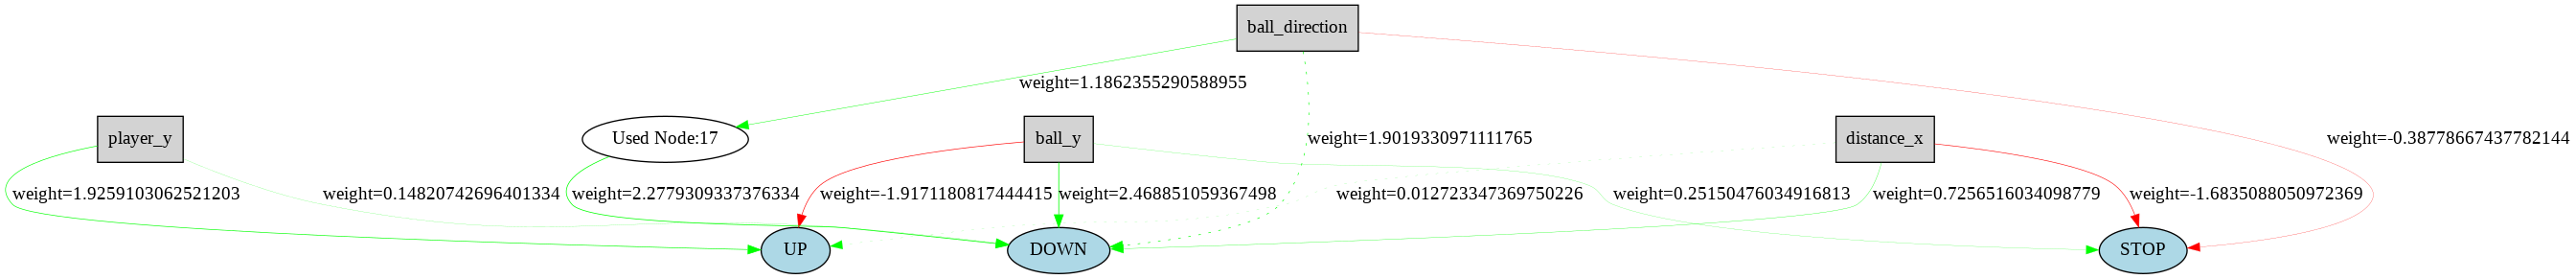

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
image_path = os.path.join(local_dir, "net.png")

image = cv2.imread(image_path)
cv2_imshow(image)

In [ ]:
def make_video():
    global FRAME
    vedio_filename = os.path.join(local_dir,'video/demo_video.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    videowriter = cv2.VideoWriter(vedio_filename, fourcc, 60, (480, 360))
    for i in range(FRAME):
        img_filename = os.path.join(local_dir,'video/'+str(i)+'.jpg')
        frame = cv2.imread(img_filename)
        videowriter.write(frame)
    videowriter.release()
make_video()

In [ ]:
from google.colab import files
files.download('/content/NEAT_for_Pong/video/demo_video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>